# Saving And Loading PyTorch Models

In [1]:
# Built-in library
import copy
import logging
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 2_000

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import (
    set_up_logger,
    create_iris_data,
    create_qwerties_data,
    smooth,
)
from src.data_manager import (
    load_data,
    create_data_loader,
    split_into_train_n_validation,
)
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

### Load MNIST Digits Data

In [2]:
fp = "../../data/mnist_digit/mnist_train.csv"
mnist_data = load_data(filename=fp)

mnist_data.head()

Shape of data: (60000, 785)



,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,2x13,2x14,2x15,2x16,2x17,2x18,2x19,2x20,2x21,2x22,2x23,2x24,2x25,2x26,2x27,2x28,3x1,3x2,3x3,3x4,3x5,3x6,3x7,3x8,3x9,3x10,3x11,3x12,3x13,3x14,3x15,3x16,3x17,3x18,3x19,3x20,3x21,3x22,3x23,3x24,3x25,3x26,3x27,3x28,4x1,4x2,4x3,4x4,4x5,4x6,4x7,4x8,4x9,4x10,4x11,4x12,4x13,4x14,4x15,4x16,4x17,4x18,4x19,4x20,4x21,4x22,4x23,4x24,4x25,4x26,4x27,4x28,5x1,5x2,5x3,5x4,5x5,5x6,5x7,5x8,5x9,5x10,5x11,5x12,5x13,5x14,5x15,5x16,5x17,5x18,5x19,5x20,5x21,5x22,5x23,5x24,5x25,5x26,5x27,5x28,6x1,6x2,6x3,6x4,6x5,6x6,6x7,6x8,6x9,6x10,6x11,6x12,6x13,6x14,6x15,6x16,6x17,6x18,6x19,6x20,6x21,6x22,6x23,6x24,6x25,6x26,6x27,6x28,7x1,7x2,7x3,7x4,7x5,7x6,7x7,7x8,7x9,7x10,7x11,7x12,7x13,7x14,7x15,7x16,7x17,7x18,7x19,7x20,7x21,7x22,7x23,7x24,7x25,7x26,7x27,7x28,8x1,8x2,8x3,8x4,8x5,8x6,8x7,8x8,8x9,8x10,8x11,8x12,8x13,8x14,8x15,8x16,8x17,8x18,8x19,8x20,8x21,8x22,8x23,8x24,8x25,8x26,8x27,8x28,9x1,9x2,9x3,9x4,9x5,9x6,9x7,9x8,9x9,9x10,9x11,9x12,9x13,9x14,9x15,9x16,9x17,9x18,9x19,9x20,9x21,9x22,9x23,9x24,9x25,9x26,9x27,9x28,10x1,10x2,10x3,10x4,10x5,10x6,10x7,10x8,10x9,10x10,10x11,10x12,10x13,10x14,10x15,10x16,10x17,10x18,10x19,10x20,10x21,10x22,10x23,10x24,10x25,10x26,10x27,10x28,11x1,11x2,11x3,11x4,11x5,11x6,11x7,11x8,11x9,11x10,11x11,11x12,11x13,11x14,11x15,11x16,11x17,11x18,11x19,11x20,11x21,11x22,11x23,11x24,11x25,11x26,11x27,11x28,12x1,12x2,12x3,12x4,12x5,12x6,12x7,12x8,12x9,12x10,12x11,12x12,12x13,12x14,12x15,12x16,12x17,12x18,12x19,12x20,12x21,12x22,12x23,12x24,12x25,12x26,12x27,12x28,13x1,13x2,13x3,13x4,13x5,13x6,13x7,13x8,13x9,13x10,13x11,13x12,13x13,13x14,13x15,13x16,13x17,13x18,13x19,13x20,13x21,13x22,13x23,13x24,13x25,13x26,13x27,13x28,14x1,14x2,14x3,14x4,14x5,14x6,14x7,14x8,14x9,14x10,14x11,14x12,14x13,14x14,14x15,14x16,14x17,14x18,14x19,14x20,14x21,14x22,14x23,14x24,14x25,14x26,14x27,14x28,15x1,15x2,15x3,15x4,15x5,15x6,15x7,15x8,15x9,15x10,15x11,15x12,15x13,15x14,15x15,15x16,15x17,15x18,15x19,15x20,15x21,15x22,15x23,15x24,15x25,15x26,15x27,15x28,16x1,16x2,16x3,16x4,16x5,16x6,16x7,16x8,16x9,16x10,16x11,16x12,16x13,16x14,16x15,16x16,16x17,16x18,16x19,16x20,16x21,16x22,16x23,16x24,16x25,16x26,16x27,16x28,17x1,17x2,17x3,17x4,17x5,17x6,17x7,17x8,17x9,17x10,17x11,17x12,17x13,17x14,17x15,17x16,17x17,17x18,17x19,17x20,17x21,17x22,17x23,17x24,17x25,17x26,17x27,17x28,18x1,18x2,18x3,18x4,18x5,18x6,18x7,18x8,18x9,18x10,18x11,18x12,18x13,18x14,18x15,18x16,18x17,18x18,18x19,18x20,18x21,18x22,18x23,18x24,18x25,18x26,18x27,18x28,19x1,19x2,19x3,19x4,19x5,19x6,19x7,19x8,19x9,19x10,19x11,19x12,19x13,19x14,19x15,19x16,19x17,19x18,19x19,19x20,19x21,19x22,19x23,19x24,19x25,19x26,19x27,19x28,20x1,20x2,20x3,20x4,20x5,20x6,20x7,20x8,20x9,20x10,20x11,20x12,20x13,20x14,20x15,20x16,20x17,20x18,20x19,20x20,20x21,20x22,20x23,20x24,20x25,20x26,20x27,20x28,21x1,21x2,21x3,21x4,21x5,21x6,21x7,21x8,21x9,21x10,21x11,21x12,21x13,21x14,21x15,21x16,21x17,21x18,21x19,21x20,21x21,21x22,21x23,21x24,21x25,21x26,21x27,21x28,22x1,22x2,22x3,22x4,22x5,22x6,22x7,22x8,22x9,22x10,22x11,22x12,22x13,22x14,22x15,22x16,22x17,22x18,22x19,22x20,22x21,22x22,22x23,22x24,22x25,22x26,22x27,22x28,23x1,23x2,23x3,23x4,23x5,23x6,23x7,23x8,23x9,23x10,23x11,23x12,23x13,23x14,23x15,23x16,23x17,23x18,23x19,23x20,23x21,23x22,23x23,23x24,23x25,23x26,23x27,23x28,24x1,24x2,24x3,24x4,24x5,24x6,24x7,24x8,24x9,24x10,24x11,24x12,24x13,24x14,24x15,24x16,24x17,24x18,24x19,24x20,24x21,24x22,24x23,24x24,24x25,24x26,24x27,24x28,25x1,25x2,25x3,25x4,25x5,25x6,25x7,25x8,25x9,25x10,25x11,25x12,25x13,25x14,25x15,25x16,25x17,25x18,25x19,25x20,25x21,25x22,25x23,25x24,25x25,25x26,25x27,25x28,26x1,26x2,26x3,26x4,26x5,26x6,26x7,26x8,26x9,26x10,26x11,26x12,26x13,26x14,26x15,26x16,26x17,26x18,26x19,26x20,26x21,26x22,26x23,26x24,26x25,26x26,26x27,26x28,27x1,27x2,27x3,27x4,27x5,27x6,27x7,27x8,27x9,27x10,27x11,27x12,27x13,27x14,27x15,27x16,27x17,27x18,27x19,27x20,

In [3]:
X = mnist_data.iloc[:, 1:]
y = mnist_data.iloc[:, 0]

X.shape, y.shape, y.unique()

((60000, 784), (60000,), array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8]))

In [4]:
# Normalize data
X_norm = X / np.max(X)  # Since np.min(X) = 0

X_norm.describe()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,2x13,2x14,2x15,2x16,2x17,2x18,2x19,2x20,2x21,2x22,2x23,2x24,2x25,2x26,2x27,2x28,3x1,3x2,3x3,3x4,3x5,3x6,3x7,3x8,3x9,3x10,3x11,3x12,3x13,3x14,3x15,3x16,3x17,3x18,3x19,3x20,3x21,3x22,3x23,3x24,3x25,3x26,3x27,3x28,4x1,4x2,4x3,4x4,4x5,4x6,4x7,4x8,4x9,4x10,4x11,4x12,4x13,4x14,4x15,4x16,4x17,4x18,4x19,4x20,4x21,4x22,4x23,4x24,4x25,4x26,4x27,4x28,5x1,5x2,5x3,5x4,5x5,5x6,5x7,5x8,5x9,5x10,5x11,5x12,5x13,5x14,5x15,5x16,5x17,5x18,5x19,5x20,5x21,5x22,5x23,5x24,5x25,5x26,5x27,5x28,6x1,6x2,6x3,6x4,6x5,6x6,6x7,6x8,6x9,6x10,6x11,6x12,6x13,6x14,6x15,6x16,6x17,6x18,6x19,6x20,6x21,6x22,6x23,6x24,6x25,6x26,6x27,6x28,7x1,7x2,7x3,7x4,7x5,7x6,7x7,7x8,7x9,7x10,7x11,7x12,7x13,7x14,7x15,7x16,7x17,7x18,7x19,7x20,7x21,7x22,7x23,7x24,7x25,7x26,7x27,7x28,8x1,8x2,8x3,8x4,8x5,8x6,8x7,8x8,8x9,8x10,8x11,8x12,8x13,8x14,8x15,8x16,8x17,8x18,8x19,8x20,8x21,8x22,8x23,8x24,8x25,8x26,8x27,8x28,9x1,9x2,9x3,9x4,9x5,9x6,9x7,9x8,9x9,9x10,9x11,9x12,9x13,9x14,9x15,9x16,9x17,9x18,9x19,9x20,9x21,9x22,9x23,9x24,9x25,9x26,9x27,9x28,10x1,10x2,10x3,10x4,10x5,10x6,10x7,10x8,10x9,10x10,10x11,10x12,10x13,10x14,10x15,10x16,10x17,10x18,10x19,10x20,10x21,10x22,10x23,10x24,10x25,10x26,10x27,10x28,11x1,11x2,11x3,11x4,11x5,11x6,11x7,11x8,11x9,11x10,11x11,11x12,11x13,11x14,11x15,11x16,11x17,11x18,11x19,11x20,11x21,11x22,11x23,11x24,11x25,11x26,11x27,11x28,12x1,12x2,12x3,12x4,12x5,12x6,12x7,12x8,12x9,12x10,12x11,12x12,12x13,12x14,12x15,12x16,12x17,12x18,12x19,12x20,12x21,12x22,12x23,12x24,12x25,12x26,12x27,12x28,13x1,13x2,13x3,13x4,13x5,13x6,13x7,13x8,13x9,13x10,13x11,13x12,13x13,13x14,13x15,13x16,13x17,13x18,13x19,13x20,13x21,13x22,13x23,13x24,13x25,13x26,13x27,13x28,14x1,14x2,14x3,14x4,14x5,14x6,14x7,14x8,14x9,14x10,14x11,14x12,14x13,14x14,14x15,14x16,14x17,14x18,14x19,14x20,14x21,14x22,14x23,14x24,14x25,14x26,14x27,14x28,15x1,15x2,15x3,15x4,15x5,15x6,15x7,15x8,15x9,15x10,15x11,15x12,15x13,15x14,15x15,15x16,15x17,15x18,15x19,15x20,15x21,15x22,15x23,15x24,15x25,15x26,15x27,15x28,16x1,16x2,16x3,16x4,16x5,16x6,16x7,16x8,16x9,16x10,16x11,16x12,16x13,16x14,16x15,16x16,16x17,16x18,16x19,16x20,16x21,16x22,16x23,16x24,16x25,16x26,16x27,16x28,17x1,17x2,17x3,17x4,17x5,17x6,17x7,17x8,17x9,17x10,17x11,17x12,17x13,17x14,17x15,17x16,17x17,17x18,17x19,17x20,17x21,17x22,17x23,17x24,17x25,17x26,17x27,17x28,18x1,18x2,18x3,18x4,18x5,18x6,18x7,18x8,18x9,18x10,18x11,18x12,18x13,18x14,18x15,18x16,18x17,18x18,18x19,18x20,18x21,18x22,18x23,18x24,18x25,18x26,18x27,18x28,19x1,19x2,19x3,19x4,19x5,19x6,19x7,19x8,19x9,19x10,19x11,19x12,19x13,19x14,19x15,19x16,19x17,19x18,19x19,19x20,19x21,19x22,19x23,19x24,19x25,19x26,19x27,19x28,20x1,20x2,20x3,20x4,20x5,20x6,20x7,20x8,20x9,20x10,20x11,20x12,20x13,20x14,20x15,20x16,20x17,20x18,20x19,20x20,20x21,20x22,20x23,20x24,20x25,20x26,20x27,20x28,21x1,21x2,21x3,21x4,21x5,21x6,21x7,21x8,21x9,21x10,21x11,21x12,21x13,21x14,21x15,21x16,21x17,21x18,21x19,21x20,21x21,21x22,21x23,21x24,21x25,21x26,21x27,21x28,22x1,22x2,22x3,22x4,22x5,22x6,22x7,22x8,22x9,22x10,22x11,22x12,22x13,22x14,22x15,22x16,22x17,22x18,22x19,22x20,22x21,22x22,22x23,22x24,22x25,22x26,22x27,22x28,23x1,23x2,23x3,23x4,23x5,23x6,23x7,23x8,23x9,23x10,23x11,23x12,23x13,23x14,23x15,23x16,23x17,23x18,23x19,23x20,23x21,23x22,23x23,23x24,23x25,23x26,23x27,23x28,24x1,24x2,24x3,24x4,24x5,24x6,24x7,24x8,24x9,24x10,24x11,24x12,24x13,24x14,24x15,24x16,24x17,24x18,24x19,24x20,24x21,24x22,24x23,24x24,24x25,24x26,24x27,24x28,25x1,25x2,25x3,25x4,25x5,25x6,25x7,25x8,25x9,25x10,25x11,25x12,25x13,25x14,25x15,25x16,25x17,25x18,25x19,25x20,25x21,25x22,25x23,25x24,25x25,25x26,25x27,25x28,26x1,26x2,26x3,26x4,26x5,26x6,26x7,26x8,26x9,26x10,26x11,26x12,26x13,26x14,26x15,26x16,26x17,26x18,26x19,26x20,26x21,26x22,26x23,26x24,26x25,26x26,26x27,26x28,27x1,27x2,27x3,27x4,27x5,27x6,27x7,27x8,27x9,27x10,27x11,27x12,27x13,27x14,27x15,27x16,27x17,27x18,27x19,27x20,27x21,

In [5]:
BATCH_SIZE = 32

# Split data into train and validation sets
X_train, X_validation, y_train, y_validation = split_into_train_n_validation(
    data=X_norm, labels=y, convert_to_long=True
)

# Dataloader objects
train_DL, validation_DL = create_data_loader(
    X_train=X_train,
    X_validation=X_validation,
    y_train=y_train,
    y_validation=y_validation,
    batch_size=BATCH_SIZE,
)

[INFO]:: 2023-06-02 23:08:15,067:: X_train: torch.Size([48000, 784])
X_validation: torch.Size([12000, 784])



In [6]:
X.shape, y.nunique()

((60000, 784), 10)

In [7]:
# Build Model
class Net(nn.Module):
    """This is used to build a Feed Forward Network architecture that
    is used for classification."""

    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(784, 32)
        self.hidden = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to implement forward prop."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden(X))
        X = torch.log_softmax(self.output(X), dim=1)
        return X


def train_model(
    *,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    epochs: int,
    learning_rate: float,
    optimizer_name: str,
):
    """This is used to train the FFN model."""
    net, PCT = Net(), 100
    __optimizer__ = getattr(torch.optim, optimizer_name)
    optimizer = __optimizer__(params=net.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    train_loss = torch.zeros(size=(epochs,))
    train_accuracy, validation_accuracy = (
        np.zeros(shape=(epochs,)),
        np.zeros(shape=(epochs,)),
    )

    print(f"Training epoch:")
    for epoch_idx in np.arange(epochs):
        net.train()
        batch_accuracy, batch_loss = [], []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()

            # Forward prop and loss
            y_proba = net(X_)
            loss = criterion(y_proba, y_)

            y_pred = torch.argmax(y_proba, dim=1)
            acc = torch.mean((y_pred == y_).float()) * PCT
            batch_accuracy.append(acc.detach())

            batch_loss.append(loss.detach())

            # Backprop
            loss.backward()
            optimizer.step()

        # Train Metrics
        train_accuracy[epoch_idx] = np.mean(batch_accuracy)
        train_loss[epoch_idx] = np.mean(batch_loss, dtype="float64")

        # Validation Metrics
        net.eval()

        X_val, y_val = next(iter(validation_dataloader))
        y_proba_val = net(X_val)
        y_pred_val = torch.argmax(y_proba_val, dim=1)
        acc_ = torch.mean((y_pred_val == y_val).float()) * PCT
        validation_accuracy[epoch_idx] = acc_
        if epoch_idx % 25 == 0:
            print(f"{epoch_idx} ", end="")

    return (train_accuracy, validation_accuracy, train_loss, net)

In [8]:
EPOCHS, LEARNING_RATE = 50, 0.01
OPTIMIZER_NAME = "SGD"

train_accuracy, validation_accuracy, train_loss, trained_net = train_model(
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER_NAME,
)

Training epoch:
0 25 

#### Save The Trained Model

In [9]:
model_path = "../../models/ffn_model_1.pt"
torch.save(trained_net.state_dict(), model_path)

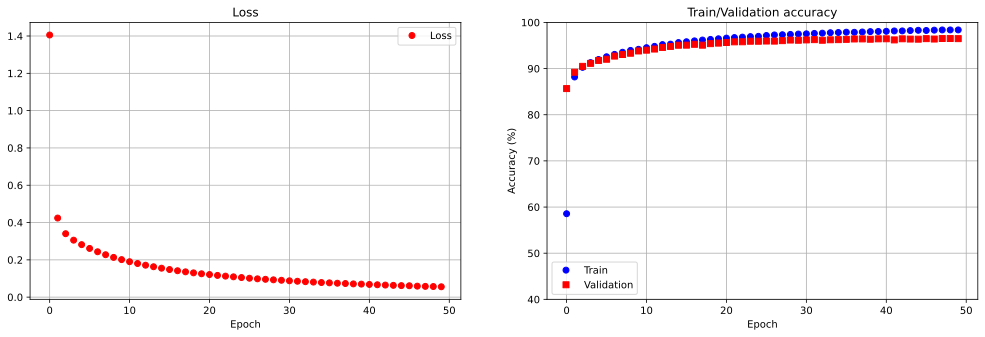

In [10]:
# Visualize the results.
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(train_loss, "ro", label="Loss")
ax[0].set_title("Loss")

ax[1].plot(train_accuracy, "bo", label="Train")
ax[1].plot(validation_accuracy, "rs", label="Validation")
ax[1].set_title("Train/Validation accuracy")

# Common features
for idx in range(2):
    ax[idx].legend(loc="best")
    ax[idx].set_xlabel("Epoch")
    if idx > 0:
        ax[idx].set_ylabel("Accuracy (%)")
        ax[idx].set_ylim(40, 100)
    ax[idx].grid()

plt.show()

#### Load The Saved Model

In [11]:
# Initialize model
model_1 = Net()

# Load the model weights
model_1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [12]:
model_1

Net(
  (input): Linear(in_features=784, out_features=32, bias=True)
  (hidden): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

## Save The Best Performing Model

```text
- Save the model weights with the best performance.
- i.e. after each epoch, check the weights with best performance.
```

In [13]:
# Simulate saving the best model weights
np.random.seed(123)
best_weight = [0, 0]

_models = np.arange(10)

for idx in _models:
    # Train the model and retrieve the accuracy
    accuracy = np.random.rand()

    # Select the model with the best accuracy
    if accuracy > best_weight[0]:
        # Save the best accuracy
        best_weight = [accuracy, idx]

best_weight

[0.9807641983846155, 6]

In [14]:
# Train Model
def train_model_with_best_weight(
    *,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    epochs: int,
    learning_rate: float,
    optimizer_name: str,
) -> tuple[torch.Tensor, np.ndarray, np.ndarray, dict[str, Any]]:
    """This is used to train the FFN model."""
    net, PCT = Net(), 100
    best_weight = {"accuracy": 0, "net": None}

    __optimizer__ = getattr(torch.optim, optimizer_name)
    optimizer = __optimizer__(params=net.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    train_loss = torch.zeros(size=(epochs,))
    train_accuracy, validation_accuracy = (
        np.zeros(shape=(epochs,)),
        np.zeros(shape=(epochs,)),
    )

    print(f"Training epoch:")
    for epoch_idx in np.arange(epochs):
        net.train()
        batch_accuracy, batch_loss = [], []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()

            # Forward prop and loss
            y_proba = net(X_)
            loss = criterion(y_proba, y_)

            y_pred = torch.argmax(y_proba, dim=1)
            acc = torch.mean((y_pred == y_).float()) * PCT
            batch_accuracy.append(acc.detach())

            batch_loss.append(loss.detach())

            # Backprop
            loss.backward()
            optimizer.step()

        # Train Metrics
        train_accuracy[epoch_idx] = np.mean(batch_accuracy)
        train_loss[epoch_idx] = np.mean(batch_loss, dtype="float64")

        # Validation Metrics
        net.eval()

        X_val, y_val = next(iter(validation_dataloader))
        y_proba_val = net(X_val)
        y_pred_val = torch.argmax(y_proba_val, dim=1)
        acc_ = torch.mean((y_pred_val == y_val).float()) * PCT
        validation_accuracy[epoch_idx] = acc_

        # =============== Check and save model weights with the best accuracy. ===============
        # Select the model with the best accuracy
        if validation_accuracy[-1] > best_weight.get("accuracy"):
            # Save the best accuracy
            best_weight["accuracy"] = acc_
            # Save the weights
            best_weight["net"] = copy.deepcopy(net.state_dict())

        if epoch_idx % 25 == 0:
            print(f"{epoch_idx} ", end="")

    return (train_accuracy, validation_accuracy, train_loss, best_weight)

In [15]:
EPOCHS, LEARNING_RATE = 50, 0.01
OPTIMIZER_NAME = "SGD"

(
    train_accuracy,
    validation_accuracy,
    train_loss,
    trained_net_dict,
) = train_model_with_best_weight(
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER_NAME,
)

Training epoch:
0 25 

In [16]:
# The best validation accuracy
trained_net_dict.get("accuracy")

tensor(96.3833)

In [17]:
# The weights that produced the best validation accuracy
trained_net_dict.get("net")

OrderedDict([('input.weight',
              tensor([[ 0.0147,  0.0030,  0.0172,  ...,  0.0304, -0.0320, -0.0179],
                      [ 0.0253,  0.0274,  0.0278,  ..., -0.0018, -0.0258,  0.0116],
                      [ 0.0082, -0.0182, -0.0143,  ...,  0.0174,  0.0096,  0.0275],
                      ...,
                      [ 0.0349,  0.0063, -0.0034,  ..., -0.0084,  0.0032, -0.0138],
                      [-0.0166, -0.0291, -0.0227,  ..., -0.0338, -0.0175,  0.0219],
                      [-0.0245, -0.0010,  0.0016,  ...,  0.0326,  0.0058, -0.0263]])),
             ('input.bias',
              tensor([ 0.2335, -0.2329, -0.0488, -0.3407, -0.1483,  0.2179, -0.0469, -0.1334,
                       0.1372,  0.0254,  0.2171,  0.1162,  0.1176,  0.2102,  0.0711, -0.0320,
                      -0.0026,  0.1141, -0.0240, -0.0557,  0.1125,  0.0281, -0.0163,  0.0758,
                      -0.0629,  0.1430, -0.1033,  0.0683,  0.3141,  0.0142, -0.0869,  0.1576])),
             ('hidden.weight'

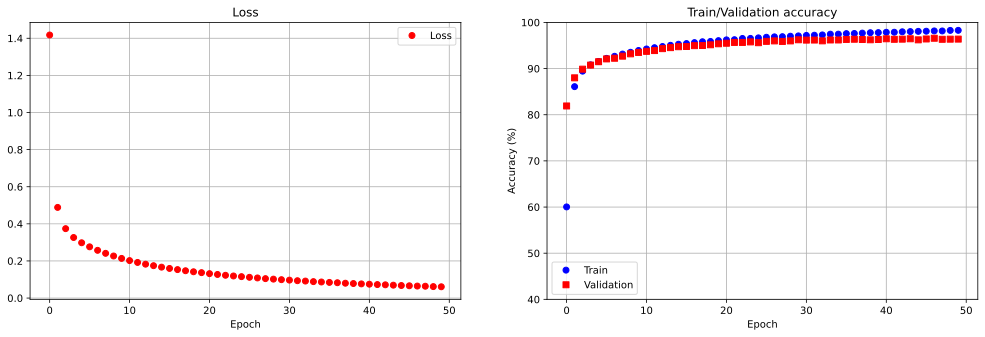

In [18]:
# Visualize the results.
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(train_loss, "ro", label="Loss")
ax[0].set_title("Loss")

ax[1].plot(train_accuracy, "bo", label="Train")
ax[1].plot(validation_accuracy, "rs", label="Validation")
ax[1].set_title("Train/Validation accuracy")

# Common features
for idx in range(2):
    ax[idx].legend(loc="best")
    ax[idx].set_xlabel("Epoch")
    if idx > 0:
        ax[idx].set_ylabel("Accuracy (%)")
        ax[idx].set_ylim(40, 100)
    ax[idx].grid()

plt.show()